In [1]:
import os
import cv2
import numpy as np
import PIL
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from skimage.exposure import match_histograms

import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CURRENT_DIR = os.path.dirname(os.path.abspath('__file__'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting Snapshots

In [2]:
def take_snaphot(video, sec):
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(sec * fps)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
    frame = video.read()[1]
    return frame

def extract_pairs(video_path1, video_path2, start_time=2, num_pairs=1, interval=10):
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)
    if not cap1.isOpened(): raise Exception(f"Error: Could not open video file {video_path1}")
    if not cap2.isOpened(): raise Exception(f"Error: Could not open video file {video_path2}")
    
    frame_pairs = [(
            Image.fromarray(take_snaphot(cap1, start_time + i*interval)),
            Image.fromarray(take_snaphot(cap2, start_time + i*interval))
        )
            for i in range(num_pairs)]

    cap1.release()
    cap2.release()

    return frame_pairs

In [ ]:
video_before_path = f"{CURRENT_DIR}/../videos/1A.MP4"
video_after_path = f"{CURRENT_DIR}/../videos/c1A.MP4"

frame_pairs = extract_pairs(video_before_path, video_after_path, start_time=2, num_pairs=6, interval=10) # set start_time to the start of the video

# Concrete Circles Cutting Out

In [3]:
checkpoint_path = f"{CURRENT_DIR}/../weights/circle_segmentation/circle_segmentation_30e_sched"
loaded_model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)

In [4]:
def get_circle(model, image, new_size=None):
    image_processor = SegformerImageProcessor(reduce_labels=True)
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(): outputs = model(pixel_values=pixel_values)
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
    numpy_image = np.array(image)
    mask = predicted_segmentation_map.astype(np.uint8)
    result = cv2.bitwise_and(numpy_image, numpy_image, mask=mask)
    coords = np.column_stack(np.where(mask))
    
    if coords.size != 0:
        top_left = coords.min(axis=0)
        bottom_right = coords.max(axis=0) + 1
        cropped_image = Image.fromarray(result).crop((*top_left[::-1], *bottom_right[::-1]))
    else: cropped_image = Image.fromarray(mask)

    if new_size:
        resizer = torchvision.transforms.Resize([new_size[0], new_size[1]])
        cropped_image = resizer.forward(cropped_image)
    return cropped_image

In [5]:
new_size = [2000, 2000] # size of the cut out circles
circles_pairs = [(get_circle(loaded_model, pair[0], new_size), get_circle(loaded_model, pair[1], new_size)) for pair in frame_pairs]

def normalize_to_start_pos(circle_pairs, interval): return [(pair[0].rotate(i*interval*(360 / 81)), pair[1].rotate(i*interval*(360 / 81))) for i, pair in enumerate(circle_pairs)]
def filter_no_circles(circle_pairs): return [pair for pair in circle_pairs if np.sum(pair[0]) != 0 and np.sum(pair[1]) != 0]
circles_pairs = filter_no_circles(circles_pairs)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


# Images Alignment

In [6]:
def histogram_matching(source, reference):
    if len(source.shape) == 2:
        source = cv2.cvtColor(source, cv2.COLOR_GRAY2RGB)
    if len(reference.shape) == 2:
        reference = cv2.cvtColor(reference, cv2.COLOR_GRAY2RGB)
    matched_image = match_histograms(source, reference, multichannel=True)
    
    return source, reference, matched_image

def mean_squared_error(image1: np.ndarray, image2: np.ndarray) -> float:
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same shape.")
    return np.mean((image1 - image2) ** 2)

In [7]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Identity()

model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def image_to_tensor(image):
    image = image.convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image.to(device)

def extract_features(image_tensor):
    with torch.no_grad():
        features = model(image_tensor)
    return features.cpu().numpy().flatten()

def generate_score(image1, image2):
    image1_tensor = image_to_tensor(image1)
    image2_tensor = image_to_tensor(image2)

    features1 = extract_features(image1_tensor)
    features2 = extract_features(image2_tensor)

    similarity = cosine_similarity([features1], [features2])
    return similarity[0][0]

In [8]:
def detect_keypoints_and_match(image1, image2, detector, matcher, k=2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    keypoints1, descriptors1 = detector.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(gray2, None)
    
    matches = matcher.knnMatch(descriptors1, descriptors2, k=k)
    
    good_matches = []
    if k >= 2:
        for m in matches:
            if len(m) >= 2 and m[0].distance < 0.75 * m[1].distance:
                good_matches.append(m[0])
    else:
        for m in matches:
            good_matches.append(m[0])
    
    return keypoints1, keypoints2, good_matches

def compute_rotation_angle(keypoints1, keypoints2, matches):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
    affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, maxIters=3000)
    angle = np.arctan2(affine_matrix[0, 1], affine_matrix[0, 0])
    angle_degrees = np.degrees(angle)
    return angle_degrees

def refine_rotation_angle(circle1, circle2, estimated_angle):
    best_angle = estimated_angle
    best_score = generate_score(circle1, circle2.rotate(estimated_angle))
    for angle in np.arange(estimated_angle - 180, estimated_angle + 180, 4):
        score = generate_score(circle1, circle2.rotate(angle))
        if best_score < score:
            best_angle = angle
            best_score = score
    return best_angle, best_score

def reverse_rotation(image1, image2, detector, matcher):
    keypoints1, keypoints2, good_matches = detect_keypoints_and_match(image1, image2, detector, matcher, k=10)
    if len(good_matches) < 3: raise ValueError("Not enough matches are found.")
    
    return compute_rotation_angle(keypoints1, keypoints2, good_matches)


def get_aligning_angle(circle1, circle2):
    resizer = torchvision.transforms.Resize([512, 512])
    resized_image1 = np.asarray(resizer.forward(circle1))
    resized_image2 = np.asarray(resizer.forward(circle2))

    gray_image1 = cv2.cvtColor(resized_image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(resized_image2, cv2.COLOR_BGR2GRAY)

    angle, _ = refine_rotation_angle(PIL.Image.fromarray(gray_image1), PIL.Image.fromarray(gray_image2), 0)
    return angle

In [9]:
aligning_angle = get_aligning_angle(circles_pairs[0][0], circles_pairs[0][1])
aligned_circle_pairs = normalize_to_start_pos([(pair[0], pair[1].rotate(aligning_angle)) for pair in circles_pairs], interval=10)

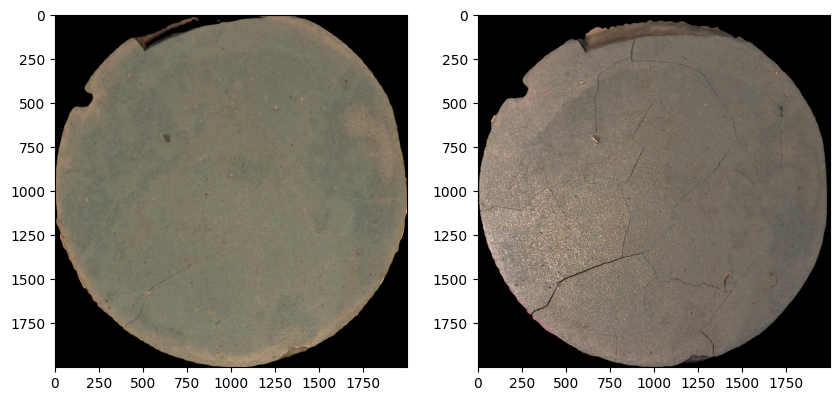

In [12]:
i = 0 # from 0 to (number of pairs - 1)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(aligned_circle_pairs[i][0])
fig.add_subplot(1, 2, 2)
plt.imshow(aligned_circle_pairs[i][1])